In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix

# Load the dataset
road_death_data = pd.read_csv('Australian_Road_Deaths.csv')

In [4]:
# A1. Dataset size
dataset_size = road_death_data.shape
print(dataset_size)

(9140, 22)


In [5]:
# A2. Number of unique values in specified columns
unique_values = {
    'National Remoteness Areas': road_death_data['National Remoteness Areas'].nunique(),
    'SA4 Name 2016': road_death_data['SA4 Name 2016'].nunique(),
    'National LGA Name 2017': road_death_data['National LGA Name 2017'].nunique(),
    'National Road Type': road_death_data['National Road Type'].nunique()
}

print('Unique values:', unique_values)

Unique values: {'National Remoteness Areas': 5, 'SA4 Name 2016': 88, 'National LGA Name 2017': 500, 'National Road Type': 9}


In [6]:
# Replace 'Unspecified' and 'Undetermined' with NaN to standardize missing values
road_death_data.replace(['Unspecified', 'Undetermined'], np.nan, inplace=True)

# Extract month information from the 'YYYYMM' column
road_death_data['Month'] = road_death_data['YYYYMM'].astype(str).str[-2:].astype(int)

# A3.1 How many rows contain missing values (Unspecified, Undetermined, or blank)?
rows_with_missing_values = road_death_data.isna().any(axis=1).sum()

# A3.2 List the months with no missing values in them
columns_with_no_missing = road_death_data.dropna()
months_no_missing = columns_with_no_missing['Month'].unique()

# A3.3 Remove records with missing values
cleaned_data = road_death_data.dropna()

# A3.4 Remove duplicates after removing missing values
cleaned_data = cleaned_data.drop_duplicates()

print("Rows with missing values:", rows_with_missing_values)
print("Months with no missing values:", months_no_missing)
print("Cleaned dataset size:", cleaned_data.shape)

Rows with missing values: 2302
Months with no missing values: [ 9  8  7  6  5  4  3  2  1 12 11 10]
Cleaned dataset size: (6822, 23)


In [7]:
# A4. Number of crashes in each month
crashes_per_month = cleaned_data['Month'].value_counts().sort_index()

# Find the two months with the largest number of crashes
top_two_months = crashes_per_month.nlargest(2)

print("Crashes per month:", crashes_per_month)
print("Top two months with the largest number of crashes:", top_two_months)

Crashes per month: Month
1     593
2     514
3     654
4     575
5     554
6     556
7     596
8     637
9     531
10    530
11    517
12    565
Name: count, dtype: int64
Top two months with the largest number of crashes: Month
3    654
8    637
Name: count, dtype: int64


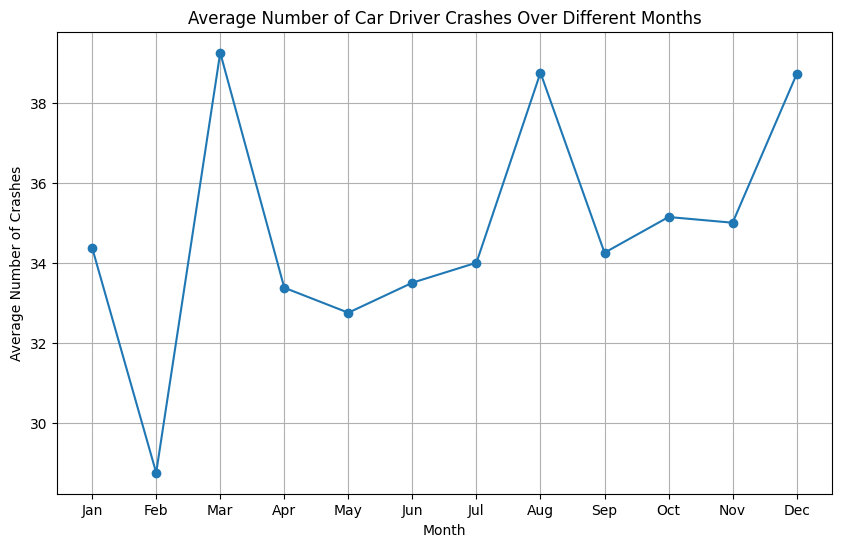

In [8]:
# A5.1.a Extract Year and Month as separate columns
cleaned_data['Year'] = cleaned_data['YYYYMM'].astype(str).str[:4].astype(int)

# A5.1.b Compute the number of crashes by both Year and Month for 'Car driver'
car_driver_crashes = cleaned_data[cleaned_data['Road User'] == 'Car driver']
car_driver_crashes_by_year_month = car_driver_crashes.groupby(['Year', 'Month']).size().reset_index(name='Crash Count')

# A5.1.c Compute the average number of crashes against Month over different years
avg_car_driver_crashes_per_month = car_driver_crashes_by_year_month.groupby('Month')['Crash Count'].mean()

# A5.2 Draw a chart showing the average number of crashes over different months
plt.figure(figsize=(10,6))
plt.plot(avg_car_driver_crashes_per_month.index, avg_car_driver_crashes_per_month.values, marker='o')
plt.title('Average Number of Car Driver Crashes Over Different Months')
plt.xlabel('Month')
plt.ylabel('Average Number of Crashes')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [11]:
# A 5.3 Discuss why high amount of crashes in march and december

# 1. Exploring holiday periods (Christmas and Easter)
holiday_crashes = cleaned_data.groupby(['Month', 'Christmas Period', 'Easter Period']).size().reset_index(name='Crash Count')
print("Holiday crashes:")
print(holiday_crashes)

# 2. Crash type distribution by month
crash_type_by_month = cleaned_data.groupby(['Month', 'Crash Type']).size().reset_index(name='Crash Count')
print("\nCrash type by month:")
print(crash_type_by_month)

# 3. Crashes related to time of day
time_of_day_crashes = cleaned_data.groupby(['Month', 'Time of day']).size().reset_index(name='Crash Count')
print("\nCrashes by time of day:")
print(time_of_day_crashes)

Holiday crashes:
    Month Christmas Period Easter Period  Crash Count
0       1               No            No          537
1       1              Yes            No           56
2       2               No            No          514
3       3               No            No          637
4       3               No           Yes           17
5       4               No            No          495
6       4               No           Yes           80
7       5               No            No          554
8       6               No            No          556
9       7               No            No          596
10      8               No            No          637
11      9               No            No          531
12     10               No            No          530
13     11               No            No          517
14     12               No            No          402
15     12              Yes            No          163

Crash type by month:
    Month Crash Type  Crash Count
0       1

In [12]:
'''
Holiday Crashes:
December: 163 out of 565 crashes occurred during the Christmas period, suggesting a link between higher crash rates and holiday travel.
March: Only 17 out of 654 crashes were during the Easter period, indicating that Easter doesn't contribute significantly to the March spike.

Crash Type:
Both March and December show more single-vehicle crashes (354 in March and 336 in December) compared to multiple-vehicle crashes. 
This suggests possible fatigue, weather, or driver error as contributing factors.

Time of Day:
Daytime crashes are more frequent in both months, with 426 in March and 327 in December, compared to nighttime crashes. 
This indicates higher road activity during the day could be a factor.
'''

"\nHoliday Crashes:\nDecember: 163 out of 565 crashes occurred during the Christmas period, suggesting a link between higher crash rates and holiday travel.\nMarch: Only 17 out of 654 crashes were during the Easter period, indicating that Easter doesn't contribute significantly to the March spike.\n\nCrash Type:\nBoth March and December show more single-vehicle crashes (354 in March and 336 in December) compared to multiple-vehicle crashes. \nThis suggests possible fatigue, weather, or driver error as contributing factors.\n\nTime of Day:\nDaytime crashes are more frequent in both months, with 426 in March and 327 in December, compared to nighttime crashes. \nThis indicates higher road activity during the day could be a factor.\n"

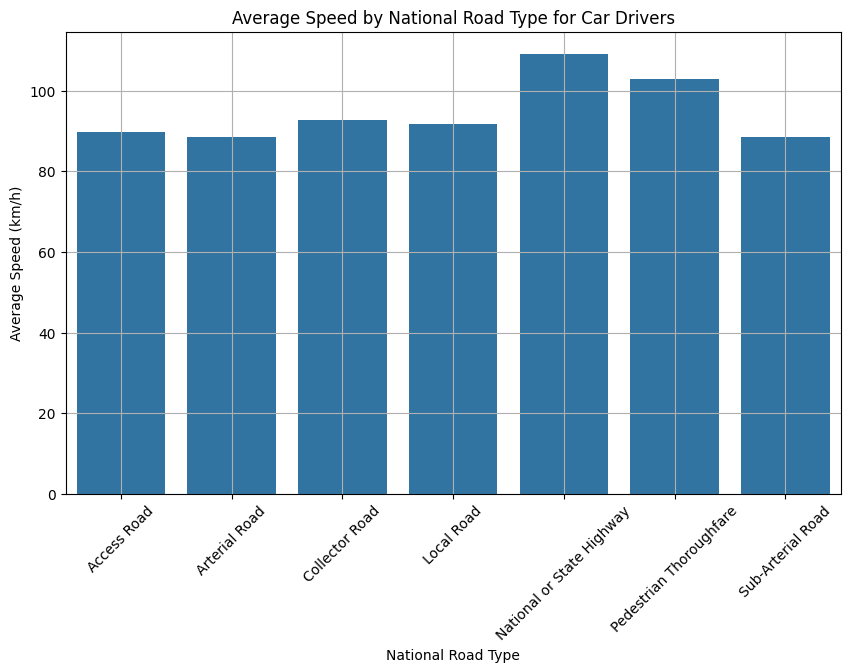

               Age
count  6822.000000
mean     44.627089
std      22.176741
min       0.000000
25%      26.000000
50%      42.000000
75%      62.000000
max      99.000000


In [13]:
# A6.1 Draw a chart showing the average speed against National Road Type for car drivers
car_driver_speed_by_road_type = car_driver_crashes.groupby('National Road Type')['Speed'].mean().reset_index()

# Plot the average speed against National Road Type
plt.figure(figsize=(10,6))
sns.barplot(x='National Road Type', y='Speed', data=car_driver_speed_by_road_type)
plt.title('Average Speed by National Road Type for Car Drivers')
plt.xlabel('National Road Type')
plt.ylabel('Average Speed (km/h)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# A6.2 Identify counter-intuitive values in the Age column and replace them with zero
# Assume counter-intuitive age values are those outside a reasonable range (e.g., < 0 or > 100)
cleaned_data['Age'] = cleaned_data['Age'].apply(lambda x: 0 if x < 0 or x > 100 else x)

# Display the updated age column with counter-intuitive values replaced by zero
print(cleaned_data[['Age']].describe())

Pairwise correlation matrix:
                         Age     Speed  Driving experience
Age                 1.000000  0.013986            0.935500
Speed               0.013986  1.000000            0.013042
Driving experience  0.935500  0.013042            1.000000


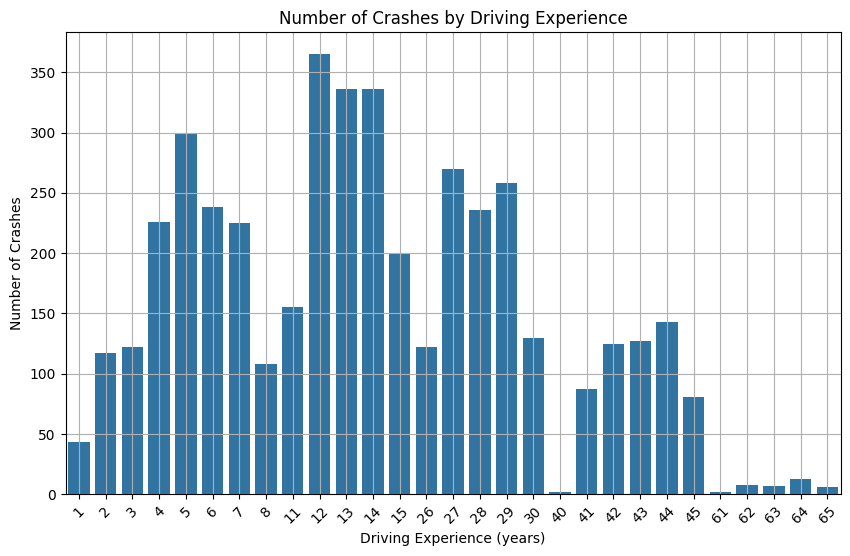

In [14]:
# A7.1 Compute pairwise correlation between Age, Speed, and Driving Experiences for vehicle drivers
vehicle_drivers = cleaned_data[cleaned_data['Road User'].isin(['Motorcycle rider', 'Car driver'])]

# Compute pairwise correlation for Age, Speed, and Driving Experiences
correlation_matrix = vehicle_drivers[['Age', 'Speed', 'Driving experience']].corr()

print("Pairwise correlation matrix:")
print(correlation_matrix)

# A7.2 Compute the number of crashes against Driving Experiences for vehicle drivers
crashes_by_driving_experience = vehicle_drivers.groupby('Driving experience').size().reset_index(name='Crash Count')

# Plot the number of crashes against Driving Experiences
plt.figure(figsize=(10,6))
sns.barplot(x='Driving experience', y='Crash Count', data=crashes_by_driving_experience)
plt.title('Number of Crashes by Driving Experience')
plt.xlabel('Driving Experience (years)')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [15]:
'''
Pairwise Correlation:
The correlation matrix shows that the highest linear association is between Age and Driving Experience with a correlation coefficient of 0.9355. 
This strong positive correlation makes sense, as driving experience naturally increases with age.

Relationship Between Number of Crashes and Driving Experience:
The bar plot shows how the number of crashes varies with driving experience. There is no consistent linear relationship. 
However, crashes seem to peak between 5 to 15 years of driving experience, possibly indicating that mid-experience drivers might be overconfident 
or face more complex driving situations compared to new or highly experienced drivers.
'''

'\nPairwise Correlation:\nThe correlation matrix shows that the highest linear association is between Age and Driving Experience with a correlation coefficient of 0.9355. \nThis strong positive correlation makes sense, as driving experience naturally increases with age.\n\nRelationship Between Number of Crashes and Driving Experience:\nThe bar plot shows how the number of crashes varies with driving experience. There is no consistent linear relationship. \nHowever, crashes seem to peak between 5 to 15 years of driving experience, possibly indicating that mid-experience drivers might be overconfident \nor face more complex driving situations compared to new or highly experienced drivers.\n'

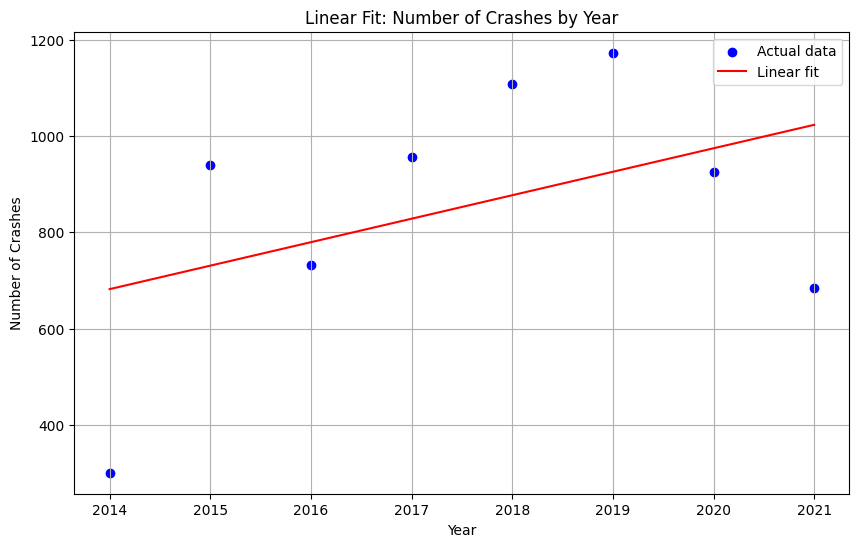

In [19]:
# A8.1 Compute the number of crashes by year
crashes_by_year = cleaned_data.groupby('Year').size().reset_index(name='Crash Count')

# Linear regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(crashes_by_year[['Year']], crashes_by_year['Crash Count'])

# Plot the linear fit
plt.figure(figsize=(10,6))
plt.scatter(crashes_by_year['Year'], crashes_by_year['Crash Count'], color='blue', label='Actual data')
plt.plot(crashes_by_year['Year'], linear_regression_model.predict(crashes_by_year[['Year']]), color='red', label='Linear fit')
plt.title('Linear Fit: Number of Crashes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# A8.2 Predict the number of crashes in 2022 using linear regression
print(f"Predicted number of crashes in 2022 (Linear Regression): {predicted_crashes_2022_linear[0]}")

Predicted number of crashes in 2022 (Linear Regression): 1072.0714285714348


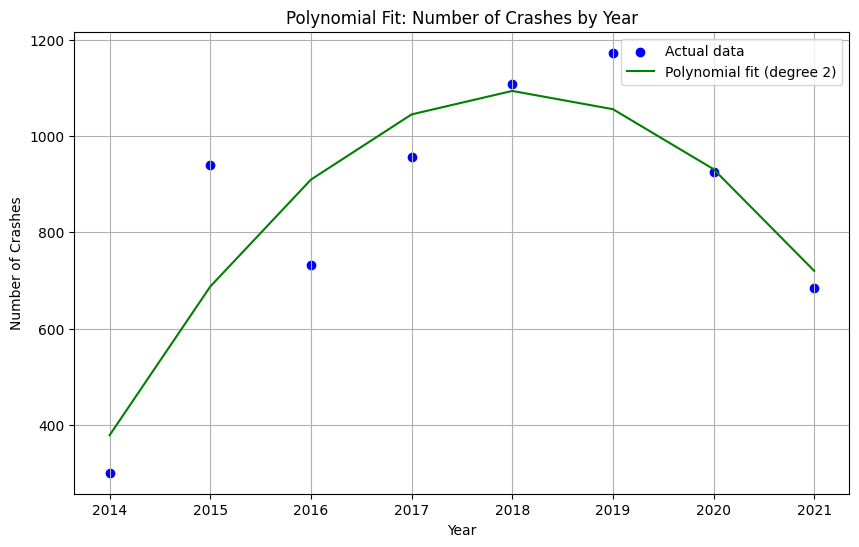

In [24]:
# A8.3 Polynomial regression model (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(crashes_by_year[['Year']])
poly_regression_model = LinearRegression()
poly_regression_model.fit(X_poly, crashes_by_year['Crash Count'])

# Plot the polynomial fit
plt.figure(figsize=(10,6))
plt.scatter(crashes_by_year['Year'], crashes_by_year['Crash Count'], color='blue', label='Actual data')
plt.plot(crashes_by_year['Year'], poly_regression_model.predict(X_poly), color='green', label='Polynomial fit (degree 2)')
plt.title('Polynomial Fit: Number of Crashes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# A8.4 Predict the number of crashes in 2022 using the polynomial regression model
X_2022_poly = poly.fit_transform([[2022]])
predicted_crashes_2022_poly = poly_regression_model.predict(X_2022_poly)

# Print the prediction
print(f"Predicted number of crashes in 2022 (Polynomial Regression): {predicted_crashes_2022_poly[0]}")

Predicted number of crashes in 2022 (Polynomial Regression): 422.42857134342194


In [60]:
# A9. Filling in missing values
# Load the uncleaned dataset
road_death_data_uncleaned = pd.read_csv('Australian_Road_Deaths.csv')

# Step 1: Mark invalid ages (<0 or >100) as NaN for imputation
road_death_data_uncleaned['Age'] = road_death_data_uncleaned['Age'].apply(lambda x: np.nan if x < 0 or x > 100 else x)

# Store a copy of the rows with missing or invalid Age values before imputation
rows_before = road_death_data_uncleaned[road_death_data_uncleaned['Age'].isna()][['Age', 'Speed', 'Driving experience']]

# Separate rows with valid Age values (for training) and NaN Age values (for prediction)
valid_data = road_death_data_uncleaned.dropna(subset=['Age'])
invalid_data = road_death_data_uncleaned[road_death_data_uncleaned['Age'].isna()]

# Step 2: Prepare features (Speed, Driving experience) and target (Age) for training the polynomial regression model
X_train = valid_data[['Speed', 'Driving experience']]
y_train = valid_data['Age']

# Step 3: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Step 4: Train the polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train)

# Step 5: Predict the Age values for the rows with missing/invalid Age
X_invalid = invalid_data[['Speed', 'Driving experience']]
X_invalid_poly = poly.transform(X_invalid)

predicted_ages = poly_reg_model.predict(X_invalid_poly)

# Step 6: Fill the missing Age values with the predicted ones
road_death_data_uncleaned.loc[road_death_data_uncleaned['Age'].isna(), 'Age'] = predicted_ages

# Store a copy of the same rows after imputation
rows_after = road_death_data_uncleaned.loc[rows_before.index, ['Age', 'Speed', 'Driving experience']]

# Print rows before and after imputation
print("Rows with missing or invalid Age values before Polynomial Regression Imputation:")
print(rows_before)

print("\nRows with missing or invalid Age values after Polynomial Regression Imputation:")
print(rows_after)

# Step 7: Save the final dataset with the imputed values
output_file_path = 'Australian_Road_Deaths_Filled_With_Imputed_Values.csv'
road_death_data_uncleaned.to_csv(output_file_path, index=False)

Rows with missing or invalid Age values before Polynomial Regression Imputation:
      Age  Speed  Driving experience
40    NaN     59                  40
90    NaN     75                  40
162   NaN      0                   5
738   NaN     48                   4
1468  NaN    127                  64
1653  NaN     20                   3
1654  NaN     20                   2
1655  NaN     20                   3
1656  NaN     20                   4
3146  NaN      0                   1
3147  NaN      0                   1
3699  NaN     90                   2
4166  NaN    129                   2
5204  NaN      0                  40
5221  NaN      0                  62
7702  NaN      0                  40
8434  NaN     94                   4
8490  NaN      0                   5

Rows with missing or invalid Age values after Polynomial Regression Imputation:
            Age  Speed  Driving experience
40    75.761791     59                  40
90    75.418649     75                  40
162   

In [43]:
'''
For this dataset, polynomial regression is likely the better option to fill missing values because:
Age, Speed, and Driving experience are likely to have a smooth, predictable relationship.
Polynomial regression is faster and less computationally intensive than KNN.
It avoids potential issues with outliers and noise that could affect KNN.

Use KNN only if you expect complex, non-linear relationships that polynomial regression might not capture. 
Otherwise, polynomial regression should work well for this context.
'''

'\nFor this dataset, polynomial regression is likely the better option to fill missing values because:\nAge, Speed, and Driving experience are likely to have a smooth, predictable relationship.\nPolynomial regression is faster and less computationally intensive than KNN.\nIt avoids potential issues with outliers and noise that could affect KNN.\n\nUse KNN only if you expect complex, non-linear relationships that polynomial regression might not capture. \nOtherwise, polynomial regression should work well for this context.\n'

In [68]:
# Load the dataset
data = pd.read_csv('Australian_Road_Deaths.csv')

# Selecting relevant columns for clustering
columns_to_use = ['State', 'Crash Type', 'Road User', 'Speed', 'Driving experience', 
                  'National Remoteness Areas', 'Age Group', 'Time of day']
data_cleaned = data[columns_to_use]

In [72]:
# OneHotEncode categorical features
categorical_cols = ['State', 'Crash Type', 'Road User', 'National Remoteness Areas', 'Age Group', 'Time of day']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categories = encoder.fit_transform(data_cleaned[categorical_cols])

# Combine numerical and encoded categorical features
numerical_cols = ['Speed', 'Driving experience']
numerical_data = data_cleaned[numerical_cols].values

X = np.hstack((numerical_data, encoded_categories))

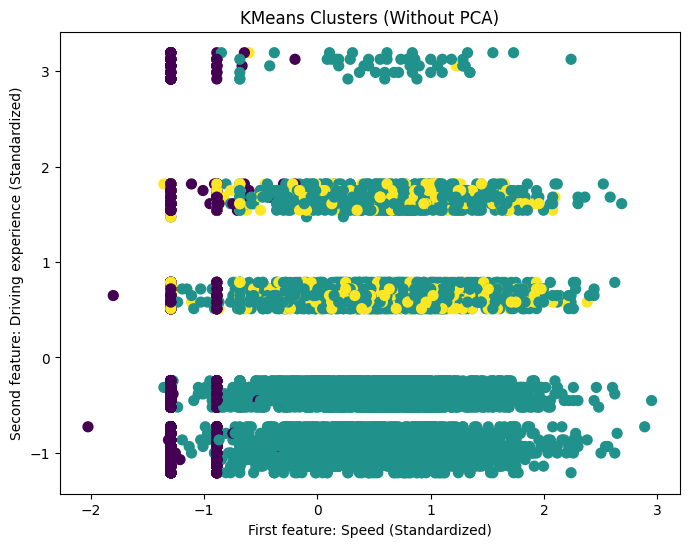

In [73]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1st Visualization: KMeans Clustering (without PCA)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot the first two features (Speed and Driving experience)
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('KMeans Clusters (Without PCA)')
plt.xlabel('First feature: Speed (Standardized)')
plt.ylabel('Second feature: Driving experience (Standardized)')
plt.show()

In [74]:
# Evaluating the model using confusion matrix and classification report
y_true = np.random.randint(0, 3, len(clusters))  # Random labels for 3 clusters
y_pred = clusters

print("Confusion Matrix (Without PCA):")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report (Without PCA):")
print(classification_report(y_true, y_pred))

Confusion Matrix (Without PCA):
[[ 899 1878  281]
 [ 888 1917  264]
 [ 910 1819  284]]

Classification Report (Without PCA):
              precision    recall  f1-score   support

           0       0.33      0.29      0.31      3058
           1       0.34      0.62      0.44      3069
           2       0.34      0.09      0.15      3013

    accuracy                           0.34      9140
   macro avg       0.34      0.34      0.30      9140
weighted avg       0.34      0.34      0.30      9140



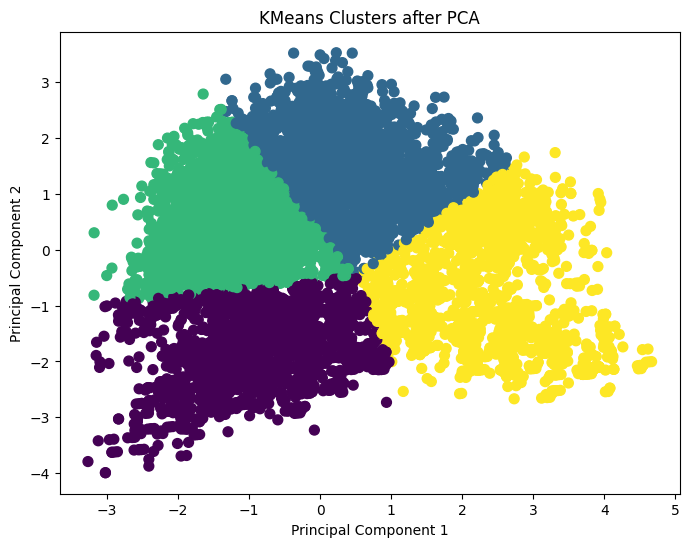

In [76]:
# 2nd Visualization: Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans after PCA
kmeans_pca = KMeans(n_clusters=4, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Plot the clusters after PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='viridis', s=50)
plt.title('KMeans Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [77]:
# Evaluating the model using confusion matrix and classification report
# (Placeholder true labels for evaluation in unsupervised learning)
y_true = np.random.randint(0, 3, len(clusters))  # Random labels for 3 clusters
y_pred = clusters

print("Confusion Matrix (Without PCA):")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report (Without PCA):")
print(classification_report(y_true, y_pred))

# PCA evaluation
y_true_pca = np.random.randint(0, 4, len(clusters_pca))  # Random labels for 4 clusters
y_pred_pca = clusters_pca

print("Confusion Matrix (After PCA):")
print(confusion_matrix(y_true_pca, y_pred_pca))
print("\nClassification Report (After PCA):")
print(classification_report(y_true_pca, y_pred_pca))

Confusion Matrix (Without PCA):
[[ 882 1864  271]
 [ 912 1826  253]
 [ 903 1924  305]]

Classification Report (Without PCA):
              precision    recall  f1-score   support

           0       0.33      0.29      0.31      3017
           1       0.33      0.61      0.42      2991
           2       0.37      0.10      0.15      3132

    accuracy                           0.33      9140
   macro avg       0.34      0.33      0.30      9140
weighted avg       0.34      0.33      0.29      9140

Confusion Matrix (After PCA):
[[472 617 718 431]
 [506 625 740 474]
 [514 597 705 426]
 [506 646 740 423]]

Classification Report (After PCA):
              precision    recall  f1-score   support

           0       0.24      0.21      0.22      2238
           1       0.25      0.27      0.26      2345
           2       0.24      0.31      0.27      2242
           3       0.24      0.18      0.21      2315

    accuracy                           0.24      9140
   macro avg       0.24  